# Liquid cities tutorial

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import numpy.testing as npt
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2018-02-14 18:28:01


In [2]:
import invisible_cities.dataflow.dataflow as fl
from invisible_cities.sierpe  import fee as FE
import invisible_cities.core.system_of_units as units

In [3]:
from functools   import wraps
from functools   import reduce
from contextlib  import contextmanager
from collections import namedtuple
from typing import  NamedTuple

## Tutorial

### Analysis flow

- Generation of toy waveforms representing the impulse response of a PMT
- Convolution with the FEE
- Deconvolution
- Comparison of the area of the original function with the area of the deconvoluted function

#### Waveform representation

In [8]:
class Waveform(NamedTuple):
    t   : np.ndarray
    q   : np.ndarray

#### A toy waveform function

- Simulate signal as a simple saw-function
- The effect of the electronics is (to first order) a HPF that introduces a derivative in the waveform

#### FEE instance (no noise)

In [53]:
fee_nn = FE.FEE(noise_FEEPMB_rms=0*units.mA, noise_DAQ_rms=0)

#### FEE instance including noise

In [54]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)

In [71]:
def input_and_fee_waveforms(fee):
    """
    generates a "theoretical" current signal (signal_i)
    """
    signal_i = np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA
    
    t = np.arange(0,np.size(signal_i),1) * units.ns
    signal_out = FE.signal_v_fee(fee, signal_i, -1) * FE.v_to_adc()
    signal_out2 = FE.noise_adc(fee, signal_out)
    
    return Waveform(t, signal_i*FE.i_to_adc()), Waveform(t, signal_out2) 

In [72]:
wf_i, wf_o = input_and_fee_waveforms(fee)

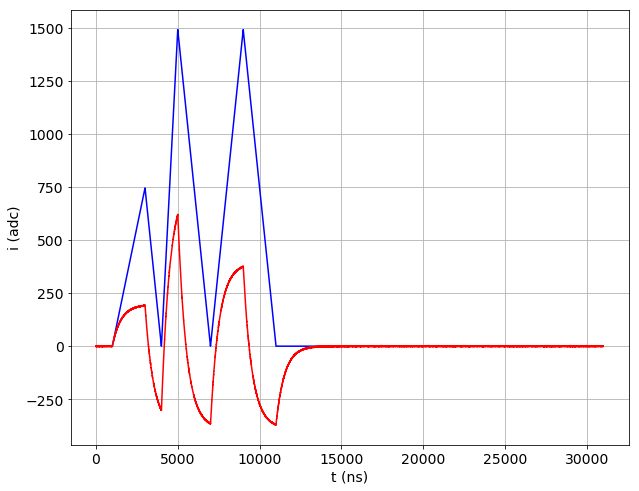

In [73]:
plt.plot(wf_i.t,wf_i.q,'b')
plt.plot(wf_o.t,wf_o.q,'r')
plt.grid(True)
plt.xlabel(r't (ns)')
plt.ylabel(r'i (adc)')

- blue: original waveform
- red : waveform after FEE electronics

In [74]:
print("TOTAL out noise (LSB_rms) = {}".format(np.std(wf_o.q[25000:26000],ddof=1)))


TOTAL out noise (LSB_rms) = 0.8699813176718617


### Deconvolution

- In the absence of noise, a simple deconvolution (deconv_simple) is sufficient.

In [67]:
print('deconvolution coefficient = {}'.format(fee.freq_LHPFd*np.pi))

deconvolution coefficient = 0.0019240095125518364


In [46]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

In [47]:
def blr(fee, wf):
    coef = fee.freq_LHPFd*np.pi
    signal_out_cf = FE.signal_clean(fee, wf.q, -1)
    signal_r, _ = deconv_simple(signal_out_cf,coef)
    return Waveform(wf.t, signal_r)
    

In [75]:
wf_r = blr(fee, wf_o)

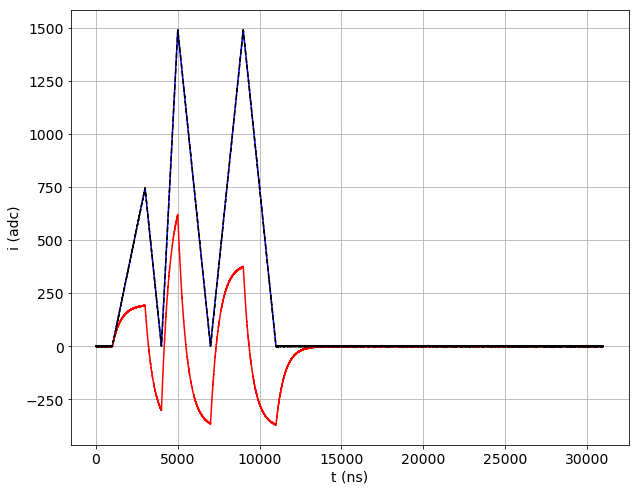

In [76]:
plt.plot(wf_i.t,wf_i.q,'b')
plt.plot(wf_o.t,wf_o.q,'r')
plt.plot(wf_r.t,wf_r.q,'k--')
plt.grid(True)
plt.xlabel(r't (ns)')
plt.ylabel(r'i (adc)')

- blue : original
- red  : convoluted with FEE
- black: deconvoluted 

#### Compare area of deconvoluted and original: show that difference is very small

In [50]:
def energy_comparison(wf_i, wf_r):
    energy_r = np.sum(wf_r.q[1000:11000])
    energy_i = np.sum(wf_i.q)
    return 100 * abs(energy_i - energy_r)/energy_i

In [96]:
def noise_calculation(wf_fee):
    return np.std(wf_fee.q[25000:26000],ddof=1)
    

In [77]:
energy_diff = energy_comparison(wf_i, wf_r)
print('Error in Energy Computation (%) = {}'.format(energy_diff))

Error in Energy Computation (%) = 0.04224976503519282


## Loop based analysis

In [97]:
events_to_run = 100
ediff = []
noise = []

for event_number in range(events_to_run):
    wf_i, wf_fee =input_and_fee_waveforms(fee)
    wf_r         = blr(fee, wf_fee)
    
    ediff.append(energy_comparison(wf_i, wf_r))
    noise.append(noise_calculation(wf_fee))

h_noise, _ = np.histogram(noise, bins=10)
h_ediff, _ = np.histogram(ediff, bins=10)


    

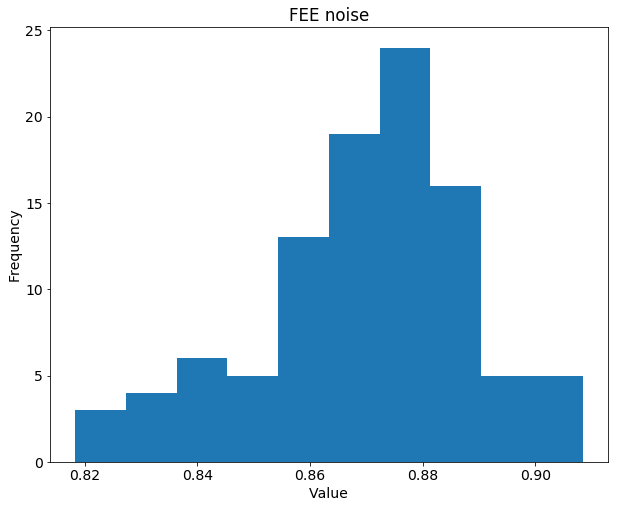

In [98]:
h2_noise, _, _ = plt.hist(noise, 10)
plt.title("FEE noise")
plt.xlabel("Value")
plt.ylabel("Frequency")

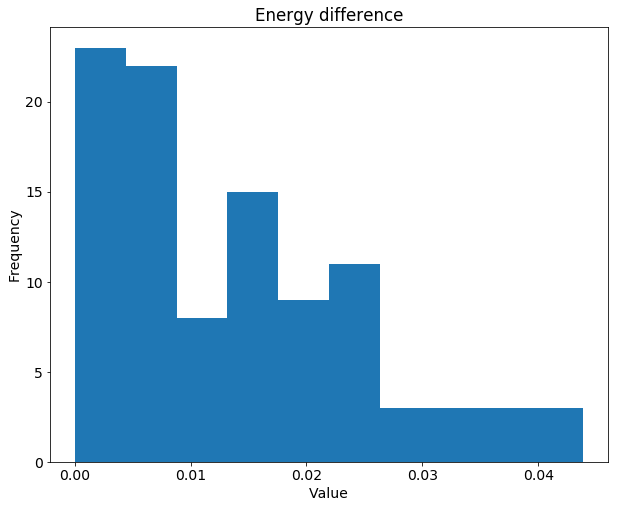

In [99]:
h2_ediff, _, _ = plt.hist(ediff, 10)
plt.title("Energy difference")
plt.xlabel("Value")
plt.ylabel("Frequency")

In [100]:
np.testing.assert_equal(h_noise, h2_noise)
np.testing.assert_equal(h_ediff, h2_ediff)

## Flow based analysis

## Analysis flow

- A flow needs: 

- A source, to generate the waveforms.
- A pipe where the data will be transformed
- A sink to collect the results of the analysis

### City components

In [168]:
def waveform_generator(fee, events):
    for event_number in range(events):
        wf_i, wf_fee =input_and_fee_waveforms(fee)
        yield dict(wf_i=wf_i,wf_fee=wf_fee,event_number=event_number )

In [169]:
def blr(fee):
    coef = fee.freq_LHPFd*np.pi
    
    def blr(wf):
        signal_out_cf = FE.signal_clean(fee, wf.q, -1)
        signal_r, _ = deconv_simple(signal_out_cf,coef)
        return Waveform(wf.t, signal_r)
    return blr

In [170]:
def energy_comparison(tmin=1000, tmax=11000):
    def energy_comparison(wf_i, wf_r):
        energy_r = np.sum(wf_r.q[tmin:tmax])
        energy_i = np.sum(wf_i.q)
        return 100 * abs(energy_i - energy_r)/energy_i
    return energy_comparison

In [171]:
def noise_calculation(tmin=1000, tmax=11000):
    def noise_calculation(wf_fee):
        return np.std(wf_fee.q[tmin:tmax],ddof=1)
    return noise_calculation

In [172]:
class histo_container(list):
    def __init__(self):
        empty_list = []
        list.__init__(self,empty_list)
    def histo(self, bins=10):
        return np.histogram(self[:], bins=bins)
        

In [152]:
x = histo_container()

In [153]:
length = 100
ys = np.random.randn(length)
for y in ys:
    x.append(y)

In [155]:
x.histo()

(array([ 3,  1,  8, 12, 19, 27, 14,  8,  6,  2]),
 array([-3.18040739, -2.59143291, -2.00245842, -1.41348394, -0.82450945,
        -0.23553497,  0.35343952,  0.942414  ,  1.53138849,  2.12036297,
         2.70933745]))

In [128]:
def print_every(N):
    counter = fl.count()
    return fl.branch(fl.map  (lambda _: next(counter), args="event_number", out="index"),
                     fl.slice(None, None, N),
                     fl.sink (lambda data: print(f"events processed: {data['index']}, event number: {data['event_number']}")))


### City of Esmeralda

In [162]:
def esmeralda(event_range=(0,100), print_mod=1, noise_f=1, noise_daq=1):
    """This city:
    - accepts waveforms ("true" and "convoluted") from the source
    - deconvolutes the waveforms
    - compares the deconvoluted ("blr") waveform with the "true" waveform, 
      producing an histogram of energy difference
    - produces an histogram of FEE noise
    """
    
    # instance of FEE
    fee = FE.FEE(noise_FEEPMB_rms=noise_f * FE.NOISE_I, noise_DAQ_rms=noise_daq * FE.NOISE_DAQ)
    
    # maps the function blr that transforms wf_fee waveforms into wf_r to the data flow. 
    # the input data  ("wf_fee") has been stored by the source in the flow dictionary
    # the output data ("wf_r") is stored by the mapping operation in the flow dictionary
    wf_fee_to_wf_r  = fl.map(blr(fee), args="wf_fee"                 , out="wf_r")
    
    # maps the function energy_comparison to the data flow: 
    # the function takes as input wf_i (initial waveform, stored by the source in the flow) and wf_r
    # obtained by the previous step. It produces as a result the energy difference between w_i and w_r
    # the result is stored in the flow dictionary as "ediff_wi_wr"
    ediff_wi_wr     = fl.map(energy_comparison(tmin=1000, tmax=11000), args=("wf_i", "wf_r"), out="ediff_wi_wr")
    
    # maps the function noise_calculation to the data flow: 
    # the function takes as input wf_fee (fee waveform, stored by the source in the flow). 
    # It produces as a result the noise of the FEE.
    # the result is stored in the flow dictionary as "noise_fee"
    noise_fee       = fl.map(noise_calculation(25000,26000), args="wf_fee"        , out="noise_fee")
    
    # The output of the calculation are two histograms, one for the energy differences between 
    # w_i and w_r, the other for the noise of the FEE. 
    
    h_ediff = histo_container()    # prepare a container for ediff
    h_noise = histo_container()    # prepare a container for noise
    
    ediff = fl.sink(h_ediff.append, args="ediff_wi_wr")   #the flow ends in a sink that fills the container
    noise = fl.sink(h_noise.append, args="noise_fee")     #the flow ends in a sink that fills the container

    event_count = fl.count()  
    
    out = fl.push(
                  source =  waveform_generator(fee, event_range[1]),
                  pipe   = fl.pipe(fl.slice(*event_range),
                                   #print_every(print_mod),
                                   wf_fee_to_wf_r,
                                   fl.fork((ediff_wi_wr, ediff),
                                           (noise_fee,   noise),
                                           (             event_count.sink))),
                  result = (event_count.future))
    return out, h_ediff, h_noise
    
                                           

In [163]:
cnt,  h_ediff, h_noise = esmeralda(event_range=(0,100), print_mod=1, noise_f=1, noise_daq=1)

In [166]:
cnt

100

In [164]:
h_ediff.histo()

(array([26, 20, 11, 16,  8,  8,  6,  2,  1,  2]),
 array([ 0.0002161 ,  0.00473416,  0.00925222,  0.01377029,  0.01828835,
         0.02280641,  0.02732447,  0.03184254,  0.0363606 ,  0.04087866,
         0.04539672]))

In [167]:
h_noise.histo()

(array([ 2,  2,  9, 12, 17, 23, 17,  8,  5,  5]),
 array([ 0.8249644 ,  0.83395683,  0.84294926,  0.85194168,  0.86093411,
         0.86992653,  0.87891896,  0.88791139,  0.89690381,  0.90589624,
         0.91488867]))